In [79]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
def generate_points_within_circle_with_boundary_check(center_x, center_y, radius, n_points, width, height):
    points_x, points_y = [], []
    while len(points_x) < n_points:
        # Generate a single point
        angle = np.random.uniform(0, 2 * np.pi)
        r = np.random.uniform(0, radius)
        x = center_x + r * np.cos(angle)
        y = center_y + r * np.sin(angle)
        
        # Check if the point is within the image boundary
        if 0 <= x < width and 0 <= y < height:
            points_x.append(x)
            points_y.append(y)
    
    return np.array(points_x), np.array(points_y)

# Parameters
def generate_image():
    n_circle_points = int(random.random()*20 + 40)
    n_random_points = int(random.random()*40 + 100)
    center_x = random.random()*80 + 20
    center_y = random.random()*80 + 60
    radius = random.random()*10 + 20
    width = 200
    height = 200
    # Generate points within a circle
    circle_points_x, circle_points_y = generate_points_within_circle_with_boundary_check(center_x, center_y, radius, n_circle_points, width, height)

    # Generate random points
    random_points_x, random_points_y = np.random.randint(0, width, n_random_points), np.random.randint(0, height, n_random_points)

    # Combine points
    points_x = np.concatenate((random_points_x, circle_points_x))
    points_y = np.concatenate((random_points_y, circle_points_y))

    # Create a new blank image
    image = np.zeros((width, height))

    # Mark points on the image
    for x, y in zip(points_x.astype(int), points_y.astype(int)):
        image[y, x] = 255  # Note the order of indices (y, x) for correct orientation

    # Convert to PIL image for better handling
    label = [center_x / width, center_y / height]
    return Image.fromarray(image).convert('RGB'), label



In [80]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# Load ResNet50 without the top layer
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(2, activation='linear')  # Output layer for the x and y coordinates
])

model.compile(optimizer='adam', loss='mean_absolute_error')

In [81]:
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import numpy as np

def generate_batch(batch_size):
    while True:  # Generator loop
        batch_images = []
        batch_labels = []
        for _ in range(batch_size):
            image, label = generate_image()  # Use the function defined earlier
            image = img_to_array(image.resize((200, 200)))  # Resize if necessary and convert to array
            batch_images.append(image)
            batch_labels.append(label)
        yield (np.array(batch_images), np.array(batch_labels))

# Define batch size and steps per epoch
batch_size = 32
steps_per_epoch = 100  # Adjust based on your dataset size

# Create generators
train_generator = generate_batch(batch_size)
validation_generator = generate_batch(batch_size)  # Ideally, you separate training and validation data

# Train the model
model.fit(train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=10,  # Number of epochs to train for
          validation_data=validation_generator,
          validation_steps=50)  # Adjust based on your validation dataset size

Epoch 1/10
100/100 [==============================] - 166s 2s/step - loss: 0.9673 - val_loss: 3.2461
Epoch 2/10
 65/100 [==================>...........] - ETA: 50s - loss: 0.4321

In [66]:
images = []
labels = []
for i in range(4):
    image, label = generate_image()
    images.append(img_to_array(image.resize((200, 200))))
    labels.append(label)
model.predict(np.array(images))

1/1 [==============================] - 0s 97ms/step


array([[0.48950592, 0.8095354 ],
       [0.7567286 , 0.60947925],
       [0.4722027 , 0.41250858],
       [0.30604964, 0.7632363 ]], dtype=float32)

In [67]:
def visul(images, labels, model):
    index = 0
    plt.imshow(images[index])
    plt.scatter(labels[index][0]*200, labels[index][1]*200, color='green', s=100, marker='x', label='Real Center')
    prediction = model.predict(np.array(images))[index]
    plt.scatter(prediction[0]*200, prediction[1]*200, color='red', s=100, marker='x', label='Predicated Center')
    plt.legend()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 33ms/step


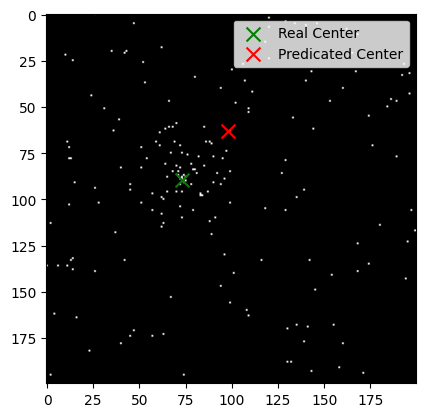

In [77]:
images = []
labels = []
for i in range(4):
    image, label = generate_image()
    images.append(img_to_array(image.resize((200, 200))))
    labels.append(label)
visul(images, labels, model)